<a href="https://colab.research.google.com/github/Berkay86/DeepPerson/blob/main/CHESSGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import glob
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
from zipfile import ZipFile
from google.colab import files
import os
     

In [4]:
import cv2
import zipfile
import os

# Extract the contents of the zip file
file = "VİDEOLARIM.zip"
with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall()

# Create a list to store the folder names
folder_names = []

# Iterate over each file in the current directory
for file in os.listdir():
    if file.endswith(".mp4"):
        # Open the video file
        cap = cv2.VideoCapture(file)

        # Create a folder name
        folder_name = os.path.splitext(file)[0]
        folder_names.append(folder_name)

        # Create a folder
        os.makedirs(folder_name)

        # Read every frame of the video
        i = 0
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break

            # Save one frame per second
            if i % 30 == 0:
                image_file_name = folder_name + "/ " +str(i/30) + ' .jpg'
                cv2.imwrite(image_file_name, frame)
            i += 1

        # Close the video file
        cap.release()
        cv2.destroyAllWindows()

# Zip all the folders and their contents into a single zip file
result_file = "result.zip"
with zipfile.ZipFile(result_file, 'w') as zip_file:
    for folder_name in folder_names:
        for root, dirs, files in os.walk(folder_name):
            for file in files:
                zip_file.write(os.path.join(root, file))

In [91]:
file2 = "/content/drive/MyDrive/RESULTS3.zip"

In [92]:
with ZipFile(file2, 'r') as zip:
    zip.printdir()
    zip.extractall()
     

File Name                                             Modified             Size
RESULTS/                                       2023-02-14 00:47:20            0
RESULTS/AnderssenStaunton1/                    2023-02-14 00:47:18            0
RESULTS/AnderssenStaunton1/ 0.0 .jpg           2023-02-13 21:32:12       101042
RESULTS/AnderssenStaunton1/ 1.0 .jpg           2023-02-13 21:32:12       115361
RESULTS/AnderssenStaunton1/ 10.0 .jpg          2023-02-13 21:32:12       116927
RESULTS/AnderssenStaunton1/ 11.0 .jpg          2023-02-13 21:32:12       117173
RESULTS/AnderssenStaunton1/ 12.0 .jpg          2023-02-13 21:32:12       116512
RESULTS/AnderssenStaunton1/ 13.0 .jpg          2023-02-13 21:32:12       116591
RESULTS/AnderssenStaunton1/ 14.0 .jpg          2023-02-13 21:32:12       116520
RESULTS/AnderssenStaunton1/ 15.0 .jpg          2023-02-13 21:32:12       116650
RESULTS/AnderssenStaunton1/ 16.0 .jpg          2023-02-13 21:32:12       116643
RESULTS/AnderssenStaunton1/ 17.0 .jpg   

In [5]:
paths = os.listdir('RESULTS')
paths

['AnderssenStaunton2',
 'StauntonAnderssen',
 'MorphyPaulsen1',
 'StauntonBird',
 'BirdAnderssen1',
 'PaulsenMorphy4',
 'AnderssenStaunton1',
 'PaulsenMorphy',
 'PaulsenMorphy1',
 'MorphyPaulsen4',
 'MorphyPaulsen5',
 'MorphyPaulsen2',
 'MorphyPaulsen',
 'BirdAnderssen',
 'MorphyPaulsen3',
 'PaulsenMorphy2',
 'StauntonAnderssen1',
 'MorphyBird',
 'PaulsenMorphy3']

In [93]:
k=[]
images = []
labels = []
m=[] 
a=[] 
     

In [321]:
for i in paths:
    path0 = '/content/RESULTS/'+ str(i)
    for path in os.listdir(path0):
        path = '/content/RESULTS/'+ str(i) + "/" + path
        #print(path)
        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,(64,64),interpolation= cv2.INTER_AREA)
        img = img/255.0
        images.append(img)
        label = path.split(" ")
        m.append(label)

In [322]:
labels1=[]
for u in range(0,len(m)):
   labels1.append(m[u][1])

In [ ]:
labels10 = np.array(labels1)
images10 = np.array(images).astype("float32")

1.0


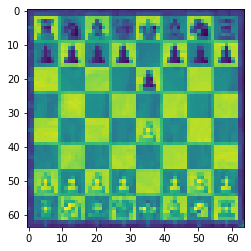

In [326]:
a=2
print(labels1[a])
plt.imshow(images[a])

1.0


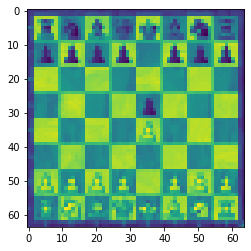

In [164]:
b=90
print(labels1[b])
plt.imshow(images[b])

In [141]:
labels10 = np.array(labels1)
images10 = np.array(images).astype("float32")

In [143]:
images10[2]

array([[0.22745098, 0.22745098, 0.22352941, ..., 0.23137255, 0.22352941,
        0.1882353 ],
       [0.21176471, 0.23921569, 0.31764707, ..., 0.2627451 , 0.23921569,
        0.21960784],
       [0.21568628, 0.31764707, 0.85882354, ..., 0.44705883, 0.2901961 ,
        0.22745098],
       ...,
       [0.21176471, 0.25490198, 0.49411765, ..., 0.85490197, 0.3254902 ,
        0.18039216],
       [0.22352941, 0.23137255, 0.2784314 , ..., 0.33333334, 0.2784314 ,
        0.31764707],
       [0.23137255, 0.21568628, 0.20784314, ..., 0.19607843, 0.31764707,
        0.44313726]], dtype=float32)

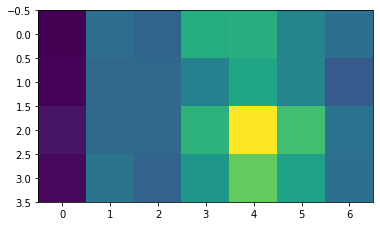

In [320]:

kale=[]
for i in range(-8,-4):
    kale.append(images[90][i][1:8])
plt.imshow(kale)

In [302]:
m2=0
m1=0
for g in range(0,100):
  for i in range(-8,0):
    print(images[g][i][0:8]==kale[i])


     


[False  True False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]


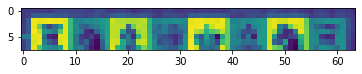

In [303]:
plt.imshow(images[90][0:8][0:8])